In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import wandb

In [21]:
MLR = 'MultinomialLogRegression'
LR = 'LinearRegressor'
MLPC = 'MLP_Classifier'
MLPR = 'MLP_Regressor'
DTC = 'DecisionTreeClassifier'
DTR = 'DecisionTreeRegressor'


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


In [6]:
class MultinomialLogRegression:
    
    def __init__(self,learning_rate,num_epoch,num_classes, num_features):
        self.learning_rate = learning_rate
        self.num_epoch = num_epoch
        self.loss = []
        self.val_acc = []
        self.val_prec = []
        self.val_rec = []
        self.val_f1 = []
        self.train_acc = []
        self.train_prec = []
        self.train_rec = []
        self.train_f1 = []
        self.num_classes = num_classes
        self.num_features = num_features

    def printParameters(self):
        print('---------------------------------------')
        print('Learning Rate  : ',self.learning_rate)
        print('Num Epoches    : ',self.num_epoch)
        print('Num Features   : ',self.num_features)
        print('Num Classes    : ',self.num_classes)
        print('---------------------------------------')
    
    def softmax(self, x):
        sm = np.exp(x)/np.sum(np.exp(x),axis=0)
        return sm
    
    def Softmax(self,z):
        exp = np.exp(z - np.max(z))
        for i in range(len(z)):
            exp[i]/=np.sum(exp[i])
        return exp
    
    def oneHotEncoding(self, y):
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def crossEntropyLoss(self,y_hat,y):
        epsilon = 1e-10
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        prob = y_hat[np.arange(len(y)), y]
        loss = -np.mean(np.log(prob))
        return loss            
    
    def fit(self,X_train,y_train,X_val, y_val):
        X = X_train
        y = y_train
        y_one_hot = self.oneHotEncoding(y)
        
        self.w = np.random.random((self.num_features,self.num_classes))
        self.b = np.random.random(self.num_classes)
        
        # gradient descent on w and b
        for epoch in range(self.num_epoch):
            y_hat = self.Softmax(X@self.w + self.b)
            del_w = np.dot(X.T,(y_hat-y_one_hot))
            del_b = np.sum(y_hat-y_one_hot)
            
            self.w = self.w - self.learning_rate*del_w
            self.b = self.b - self.learning_rate*del_b
            
            l = self.crossEntropyLoss(y_hat,y)
            self.loss.append(l)
#             wandb.log({"loss": l, "epoch": epoch}) 
            
            
            # storing validation accuracy and loss (and other metrics)
            self.validate(X_val,y_val)
            
            # storing training accuracy and loss
            y_hat = self.Softmax(X_train@self.w + self.b)
            y_pred_train = np.argmax(y_hat,axis=1)
            acc = accuracy_score(y_train, y_pred_train)
            precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted', zero_division=1)
            self.train_acc.append(acc)
            self.train_prec.append(precision)
            self.train_rec.append(recall)
            self.train_f1.append(f1)
            
            
#             wandb.log({"Train Accuracy": acc, "epoch": epoch}) 
#             wandb.log({"accuracy": acc, "loss": l})
            # if (epoch % (self.num_epoch//10)) ==0:
            #     print('Epoch : ',epoch,' Loss : ',l)
            
        
    def validate(self,X_val, y_val):
        y_hat = self.Softmax(X_val@self.w + self.b)
        y_pred_val = np.argmax(y_hat,axis=1)
        # uncomment this to print classification report after each validation
        # print(classification_report(self.y_val, y_pred_val,zero_division=1))
    
        acc = accuracy_score(y_val, y_pred_val)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_val, average='weighted', zero_division=1)

        self.val_acc.append(acc)
        self.val_prec.append(precision)
        self.val_rec.append(recall)
        self.val_f1.append(f1)

    def predict(self,X_test,y_test, X_val,y_val):
        y_hat = self.Softmax(X_test@self.w + self.b)
        self.y_pred = np.argmax(y_hat,axis=1)
        cr = classification_report(self.y_pred, y_test, zero_division=1)
        # print(cr)
        return self.y_pred,y_hat,cr
#         print('Test Accuracy : ',round(accuracy_score(self.y_test, self.y_pred),3))
#         precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, self.y_pred, average='weighted', zero_division=1)
#         print('Precision     : ',round(precision,3))
#         print('Recall        : ',round(recall,3))
#         print('f1 score      : ',round(f1,3))

        

        
        

In [7]:
class LinearRegressor:
    def __init__(self):
        self.coefficients = None
        self.intercept = None
        self.confidence_metric = None

    def fit(self, X_train, y_train):
        # Add a bias term to the input features
        X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]

        # Compute the coefficients using the normal equation
        self.coefficients = np.linalg.inv(X_train_bias.T.dot(X_train_bias)).dot(X_train_bias.T).dot(y_train)

        # Extract the intercept and coefficients
        self.intercept = self.coefficients[0]
        self.coefficients = self.coefficients[1:]

    def predict(self, X,y):
        # Add a bias term to the input features
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]

        # Predict the target values
        predictions = X_bias.dot(np.insert(self.coefficients, 0, self.intercept))

        return predictions

    def compute_confidence_metric(self, X_val, y_val):
        # Check for NaN values in input features or target values
        if np.isnan(np.sum(X_val)) or np.isnan(np.sum(y_val)):
            self.confidence_metric = np.nan
        else:
            # Use the validation set to compute a performance metric
            predictions = self.predict(X_val,y_val)

            # Calculate Mean Squared Error as a performance metric
            mse = np.mean((y_val - predictions) ** 2)

            # Confidence metric is the inverse of MSE (higher confidence for lower MSE)
            self.confidence_metric = 1 / (1 + mse)

        return self.confidence_metric

    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        """
        Plot predictions and actual values on the same graph as a line plot.

        Parameters:
        - predictions: Numpy array of predicted values
        - actual: Numpy array of actual values
        - title: Title of the plot (default is "Predictions vs Actual")
        """
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()


In [8]:
class MLP_Classifier:
    
    def __init__(self,layer_sizes, batch_size, num_epoches, learning_rate, activation_function, optimization):
        self.layer_sizes = layer_sizes # number of neurons in each layer
        self.num_layers = len(self.layer_sizes) # total number of layers
        self.batch_size = batch_size # only for mini-batch gradient descent
        self.epoches = num_epoches
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimization = optimization
        
        # initializing weights (needed once only)
        self.initialize_weights()
        
        # validation loss and acc
        self.validation_loss = []
        self.validation_accuracy = []
        
        # training loss and acc
        self.L = []
        self.A = []
        
        # print('Initialized values successfully!')
    
    def printParameters(self):
        print('-----------------------------------------------')
        print('Number of Layers       : ',self.num_layers)
        print('Layer sizes            : ',self.layer_sizes)
        print('Batch size             : ',self.batch_size)
        print('Activation Function    : ',self.activation_function)
        print('Optimization Method    : ',self.optimization)
        print('Learning Rate          : ',self.learning_rate)
        print('Num Epoches            : ',self.epoches)
        print('-----------------------------------------------')

    
    # loads the dataframe into the class
    def loadData(self,df):
        self.num_features = df.shape[1]-1
        self.num_classes = df.iloc[:, -1].nunique()
        # print('Loaded Dataframe!')

        
    # returns the one-hot encoded version of a given vector
    def oneHotEncoding(self, y):
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.argmax(x,axis=1)
        return categorical

# defining activation functions and their derivatives
#--------------------------------------------------------------------------------------------

    # SIGMOID
    def sigmoid(self,z):
        val = 1/(1+np.exp(-z))
        return val
    def sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    # ReLU 
    def ReLU(self, z):
        ret = np.maximum(z, 0)
        if ret.shape!=z.shape:
            print('whaat??')
        return ret
    def ReLU_prime(self, h):
        return np.where(h >= 0, 1, 0)
    
    # tanh
    def hyperbolic_tan(self, z):
#         val = (2/(np.exp(-2*z)+1)) -1
        val = expit(2 * z) - 1

        return val
    def hyperbolic_tan_prime(self, h):
        return 1-h**2
    
    # linear (can change slope and intercept)
    def linear(self, z):
        return z
    def linear_prime(self,h):
        return 1
    
#-----------------activation function for last layer (output) -------------------------------

    def softmax(self,z):
        ar = np.exp(z-np.max(z))
        return ar/ar.sum(axis=1,keepdims=True)
#         exp = np.exp(z - np.max(z))
#         for i in range(len(z)):
#             exp[i]/=np.sum(exp[i])
#         return exp
    


#---------------------------------------------------------------------------------------------

    def activation(self,z):
        if z.any()>=1e2:
            print('z = ',z)
        if self.activation_function=='sigmoid':
            return self.sigmoid(z)
        elif self.activation_function=='ReLU':
            return self.ReLU(z)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan(z)
        elif self.activation_function=='linear':
            return self.linear(z)
        else:
            raise ValueError("Invalid Activation function")

    def activation_prime(self,h):
        if self.activation_function=='sigmoid':
            return self.sigmoid_prime(h)
        elif self.activation_function=='ReLU':
            return self.ReLU_prime(h)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan_prime(h)
        elif self.activation_function=='linear':
            return self.linear_prime(h)
        else:
            raise ValueError("Invalid Activation function")

#---------------------------------------------------------------------------------------------


    def loss(self, y_hat, y):
        epsilon = 1e-7
        y_hat = y_hat + epsilon
        # adding small value to avoid underflow
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_hat))*y).mean()
    
    def accuracy(self, y_hat, y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.sum(y_hat==(y))/len(y_hat)


    
    def initialize_weights(self):
        self.weights = []
        #weights[i] is a m,n matrix giving weight connecting the i and i+1th layer
        
        min_weight = -1
        max_weight = 1
        for i in range(self.num_layers-1):
            sz = [self.layer_sizes[i],self.layer_sizes[i+1]]
            wt = np.random.uniform(min_weight,max_weight,size=sz)
            self.weights.append(wt)
        
#         self.weights = np.asarray(self.weights)
        
    def initialize_layers(self,batch_size):
        self.hidden_layers = [np.ones((batch_size,layer_size)) for layer_size in self.layer_sizes]
        
    # takes in a batch of data (num_samples x num_features) and applies feed-forward on it
    def feedforward(self, batch):
        current_layer = batch
        self.hidden_layers[0] = batch
        
        # next_layer = activation(weights . current_leyer) and storing while feed-forward
        for i,weights in enumerate(self.weights):
            current_layer = self.activation(np.dot(current_layer,weights))
            self.hidden_layers[i+1] = current_layer
            
        # softmax of the last layer is the output layer
        self.output_layer = self.softmax(self.hidden_layers[-1])
        
    # goes from the last layer to the 1st layer updating weights according to GD
    def backpropogation(self, y):
        y = self.oneHotEncoding(y)
        # evaluating the last layer error : del
        del_t = -(y - self.output_layer)*self.activation_prime(self.hidden_layers[-1])
        
        for i in range(1,self.num_layers):
            # calculating the gradient of weights and applying gradient-descent
            dJ_dW = np.dot(self.hidden_layers[-i-1].T,del_t)/self.batch_size
            self.weights[-i] = self.weights[-i] - self.learning_rate * dJ_dW
            # updating the error for the next layer 
            del_t = np.dot(del_t,self.weights[-i].T)*self.activation_prime(self.hidden_layers[-i-1])
                    
    def validate(self,X_val,y_val):
        n,m = X_val.shape[0:2]
        self.initialize_layers(batch_size=n)
        self.feedforward(X_val)
        val_loss = self.loss(self.output_layer,self.oneHotEncoding(y_val))
        val_acc = self.accuracy(self.categorical(self.output_layer),y_val)
        self.validation_loss.append(val_loss)
        self.validation_accuracy.append(val_acc)
        
    def mini_batch_GD(self,X_train,y_train):
            self.initialize_layers(self.batch_size)
            loss_sum = 0
            accuracy_sum = 0
            
            # calculating the total number of batches (acc to batch sizee)
            num_batches = X_train.shape[0]/self.batch_size
            ind = np.random.permutation(X_train.shape[0])
            
            # splitting the X_train, Y_train into batches
            X_batches = np.array_split(X_train[ind], num_batches)
            Y_batches = np.array_split(y_train[ind], num_batches)
            data_batches = zip(X_batches,Y_batches)
            
            # performing feed-forward -> saving training loss and accuracy -> back-propogation
            for data_x, data_y in data_batches:
                self.feedforward(data_x)
                loss_sum = loss_sum + self.loss(self.output_layer,self.oneHotEncoding(data_y))
                accuracy_sum = accuracy_sum + self.accuracy(self.categorical(self.output_layer),data_y)
                self.backpropogation(data_y)
            
            loss_train = loss_sum/num_batches
            acc_train = accuracy_sum/num_batches
            
            return loss_train, acc_train
        
    def batch_GD(self,X_train,y_train):
        self.batch_size = X_train.shape[0]
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train)
        return loss_train, acc_train
        
    def SGD(self,X_train,y_train):
        self.batch_size = 1
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train)
        return loss_train, acc_train
    
    # general method for optimization (batch/mini-batch/SGD)
    def optimize(self,X_train,y_train):
        if self.optimization=='mini-batch':
            return self.mini_batch_GD(X_train,y_train)
        elif self.optimization=='batch':
            return self.batch_GD(X_train,y_train)
        elif self.optimization=='SGD':
            return self.SGD(X_train,y_train)
    
    def fit(self,X_train,y_train,X_val,y_val):
        for epoch in range(self.epoches):
            # Gradient Descent
            loss_train, acc_train = self.optimize(X_train,y_train)
            
            # calculating accuracy and loss for current epoch and saving them
            self.L.append(loss_train)
            self.A.append(acc_train)
            
            # testing the current model on validation set and saving the loss and accuracy
            self.validate(X_val,y_val)
            # if (epoch%(self.epoches//10)==0):
                # print('Epoch : ',epoch+1,' loss : ',loss_train.round(3),' acc : ',acc_train.round(3))
#             wandb.log({"acc": acc_train.round(3), "loss": loss_train.round(3)})
            
            
    def predict(self,X_test,y_test,X_val,y_val):
        self.feedforward(X_test)
        cr = classification_report(self.categorical(self.output_layer),y_test,zero_division=1)
        self.predictions = self.categorical(self.output_layer)
        # print(self.predictions)
        # print(self.output_layer)
        return self.predictions,self.output_layer,cr
        # return self.predictions,cr
        # print('------------------------------------------------------\n',cr,'\n------------------------------------------------------\n')

                

In [9]:
class MLP_Regressor:
    
    def __init__(self,layer_sizes, batch_size, num_epoches, learning_rate, activation_function, optimization):
        self.layer_sizes = layer_sizes # number of neurons in each layer
        self.num_layers = len(self.layer_sizes) # total number of layers
        self.batch_size = batch_size # only for mini-batch gradient descent
        self.epoches = num_epoches
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimization = optimization
        
        # initializing weights (needed once only)
        self.initialize_weights()
        
        # validation loss and acc
        self.validation_loss = []
        self.validation_accuracy = []
        
        # training loss and acc
        self.L = []
        self.A = []
        
        # print('Initialized values successfully!')
    
    def printParameters(self):
        print('-----------------------------------------------')
        print('Number of Layers          : ',self.num_layers)
        print('Layer sizes               : ',self.layer_sizes)
        print('Batch size(if mini-batch) : ',self.batch_size)
        print('Activation Function       : ',self.activation_function)
        print('Optimization Method       : ',self.optimization)
        print('Learning Rate             : ',self.learning_rate)
        print('Num Epoches               : ',self.epoches)
        print('-----------------------------------------------')

    
    # loads the dataframe into the class
    def loadData(self,df):
        self.num_features = df.shape[1]-1
        self.num_classes = df.iloc[:, -1].nunique()
        self.df = df
        # print('Loaded Dataframe!')

    # splits the dataframe loaded into train, validation and test sets
    # def splitData(self,train_fraction,normalize):
    #     X = df.iloc[:, :-1].values
        
    #     # Replace NaN values with the constant k
    #     nan_mask = np.isnan(X)
    #     k = 0
    #     X[nan_mask] = k

    #     if normalize:
    #         mean = np.mean(X, axis=0)
    #         std = np.std(X, axis=0)
    #         X = (X - mean) / std
    #     y = df.iloc[:, -1].values
        

    #     self.X_train, X_temp, self.y_train, y_temp = train_test_split(X, y, test_size=1-train_fraction, random_state=42)
    #     self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    #     print('Splitted data into train, test and val sets!')
        
        
    # returns the one-hot encoded version of a given vector
    def oneHotEncoding(self, y):
        return y
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def categorical(self,x):  
        return x
    
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.argmax(x,axis=1)
        return categorical

# defining activation functions and their derivatives
#--------------------------------------------------------------------------------------------

    # SIGMOID
    def sigmoid(self,z):
        val = 1/(1+np.exp(-z))
        return val
    
    def sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    # ReLU 
    def ReLU(self, z):
        ret = np.maximum(z, 0)
        if ret.shape!=z.shape:
            print('whaat??')
        return ret
    def ReLU_prime(self, h):
        return np.where(h >= 0, 1, 0)
    
    # tanh
    def hyperbolic_tan(self, z):
        val = (2/(np.exp(-2*z)+1)) -1
        val = expit(2 * z) - 1
        return val
    
    def hyperbolic_tan_prime(self, h):
        return 1-h**2
    
    # linear (can change slope and intercept)
    def linear(self, z):
        return z
    def linear_prime(self,h):
        return 1
    
#-----------------activation function for last layer (output) -------------------------------



#---------------------------------------------------------------------------------------------

    def activation(self,z):
        if self.activation_function=='sigmoid':
            return self.sigmoid(z)
        elif self.activation_function=='ReLU':
            return self.ReLU(z)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan(z)
        elif self.activation_function=='linear':
            return self.linear(z)
        else:
            raise ValueError("Invalid Activation function")

    def activation_prime(self,h):
        if self.activation_function=='sigmoid':
            return self.sigmoid_prime(h)
        elif self.activation_function=='ReLU':
            return self.ReLU_prime(h)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan_prime(h)
        elif self.activation_function=='linear':
            return self.linear_prime(h)
        else:
            raise ValueError("Invalid Activation function")

#---------------------------------------------------------------------------------------------


    def loss(self, y_hat, y):
        y = y.reshape(-1,1)
        return np.sum((y_hat-y)**2)
    
    def accuracy(self, y_hat, y):  
        nan_mask = np.isnan(y)
        k = 0
        y[nan_mask] = k
        nan_mask = np.isnan(y_hat)
        k = 0
        y_hat[nan_mask] = k
        

        mse = mean_squared_error(y_hat, y)
        return mse


    def initialize_weights(self):
        self.weights = []
        #weights[i] is a m,n matrix giving weight connecting the i and i+1th layer
        
        mean_weight = 0  # Mean of the normal distribution
        std_dev_weight = 1  # Standard deviation of the normal distribution
        min_weight = -1
        max_weight = 1
        for i in range(self.num_layers-1):
            sz = [self.layer_sizes[i],self.layer_sizes[i+1]]
            wt = np.random.normal(mean_weight, std_dev_weight, size=sz)

            self.weights.append(wt)
        
    def initialize_layers(self,batch_size):
        self.hidden_layers = [np.ones((batch_size,layer_size)) for layer_size in layer_sizes]
        
    # takes in a batch of data (num_samples x num_features) and applies feed-forward on it
    def feedforward(self, batch):
        current_layer = batch
        self.hidden_layers[0] = batch

        for i,weights in enumerate(self.weights):
            current_layer = self.activation(np.dot(current_layer,weights))

            self.hidden_layers[i+1] = current_layer
            
        # last layer is the output layer
        self.output_layer = (self.hidden_layers[-1])
        
    # goes from the last layer to the 1st layer updating weights according to GD
    def backpropogation(self, y):
        # evaluating the last layer error : del
        y = y.reshape(-1, 1)
        del_t = -(y - self.output_layer)
        for i in range(1,self.num_layers):
            # calculating the gradient of weights and applying gradient-descent
            dJ_dW = np.dot(self.hidden_layers[-i-1].T,del_t)/self.batch_size
            self.weights[-i] = self.weights[-i] - self.learning_rate * dJ_dW
            # updating the error for the next layer 
            del_t = np.dot(del_t,self.weights[-i].T)*self.activation_prime(self.hidden_layers[-i-1])
                    
    def validate(self,X_val,y_val):
        n,m = X_val.shape[0:2]
        self.initialize_layers(batch_size=n)
        self.feedforward(X_val)
        val_loss = self.loss(self.output_layer,y_val)
        val_acc = self.accuracy(self.categorical(self.output_layer),y_val)
        self.validation_loss.append(val_loss)
        self.validation_accuracy.append(val_acc)
        
    def mini_batch_GD(self,X_train,y_train,X_val,y_val):
            self.initialize_layers(self.batch_size)
            loss_sum = 0
            accuracy_sum = 0
            
            # calculating the total number of batches (acc to batch sizee)
            num_batches = X_train.shape[0]/self.batch_size
            ind = np.random.permutation(X_train.shape[0])
            
            
            # splitting the X_train, Y_train into batches
            X_batches = np.array_split(X_train[ind], num_batches)
            Y_batches = np.array_split(y_train[ind], num_batches)
            data_batches = zip(X_batches,Y_batches)
            
            # performing feed-forward -> saving training loss and accuracy -> back-propogation
            for data_x, data_y in data_batches:
                self.feedforward(data_x)

                loss_sum = loss_sum + self.loss(self.output_layer,data_y)
                accuracy_sum = accuracy_sum + self.accuracy(self.categorical(self.output_layer),data_y)
                self.backpropogation(data_y)
            
            loss_train = loss_sum/num_batches
            acc_train = accuracy_sum/num_batches
            
            return loss_train, acc_train
        
    def batch_GD(self,X_train,y_train,X_val,y_val):
        self.batch_size = X_train.shape[0]
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train,X_val,y_val)
        return loss_train, acc_train
        
    def SGD(self,X_train,y_train,X_val,y_val):
        self.batch_size = 1
        loss_train, acc_train = self.mini_batch_GD(X_train,y_train,X_val,y_val)
        return loss_train, acc_train
    
    # general method for optimization (batch/mini-batch/SGD)
    def optimize(self,X_train,y_train,X_val,y_val):
        if self.optimization=='mini-batch':
            return self.mini_batch_GD(X_train,y_train,X_val,y_val)
        elif self.optimization=='batch':
            return self.batch_GD(X_train,y_train,X_val,y_val)
        elif self.optimization=='SGD':
            return self.SGD(X_train,y_train,X_val,y_val)
    
    def fit(self,X_train,y_train,X_val,y_val):
        for epoch in range(self.epoches):
            # Gradient Descent
            loss_train, acc_train = self.optimize(X_train,y_train,X_val,y_val)
            
            # calculating accuracy and loss for current epoch and saving them
            self.L.append(loss_train)
            self.A.append(acc_train)
            
            # testing the current model on validation set and saving the loss and accuracy
            self.validate(X_val,y_val)
            # if (epoch%(0.1*self.epoches)==0):
            #     print('Epoch : ',epoch+1,' loss : ',loss_train.round(3),' acc : ',acc_train.round(3))


    def compute_confidence_metric(self,X_val,y_val):
        # y_val = y_val.reshape(-1,1)
        self.feedforward(X_val)
        predictions = self.output_layer
        mse = np.mean((y_val - predictions) ** 2)
        # Confidence metric is the inverse of MSE (higher confidence for lower MSE)
        self.confidence_metric = 1 / (1 + mse)
        return self.confidence_metric

            
    def predict(self,X_test,y_test):
        # y_test = y_test.reshape(-1,1)
        self.feedforward(X_test)
        
        # plt.plot(self.output_layer,label='Predicted')
        # plt.plot(self.y_test,label='Ground Truth')
        # plt.title('Predicted Values vs Ground Truth')
        # plt.grid()
        # plt.xlabel('Sample')
        # plt.ylabel('Value')
        # plt.legend()
        # plt.show()
        
        output_layer = self.output_layer
        return output_layer
        
        # print('--------------------------------------------------------------------------------')
        
        # # Calculate Mean Squared Error (MSE)
        # mse = mean_squared_error(y_test, output_layer)
        # print(f'Mean Squared Error (MSE)                 : {mse:.2f}')

        # # Calculate Root Mean Squared Error (RMSE)
        # rmse = np.sqrt(mse)
        # print(f'Root Mean Squared Error (RMSE)           : {rmse:.2f}')

        # # Calculate R-squared (Coefficient of Determination)
        # r_squared = r2_score(y_test, output_layer)
        # print(f'R-squared (Coefficient of Determination) : {r_squared:.2f}')
        
        # print('--------------------------------------------------------------------------------')
        
    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        """
        Plot predictions and actual values on the same graph as a line plot.

        Parameters:
        - predictions: Numpy array of predicted values
        - actual: Numpy array of actual values
        - title: Title of the plot (default is "Predictions vs Actual")
        """
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



In [10]:
class MyDecisionTreeClassifier:
    def __init__(self, **kwargs):
        """
        Initialize the Decision Tree Classifier.

        Parameters:
        - **kwargs: Any additional arguments accepted by DecisionTreeClassifier
        """
        self.model = DecisionTreeClassifier(**kwargs)

    def fit(self, X_train, y_train):
        """
        Fit the Decision Tree Classifier to the training data.

        Parameters:
        - X_train: Training features
        - y_train: Training labels
        """
        self.model.fit(X_train, y_train)

    def validate(self,X_val, y_val):
        predictions = self.model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        return accuracy

    
    def predict(self, X_test,y_test,X_val, y_val):
        """
        Predict labels, soft assignments, and provide the classification report.

        Parameters:
        - X_test: Test features

        Returns:
        - predictions: Predicted labels
        - soft_assignments: Soft assignments for each prediction
        - report: Classification report
        """
        value = self.validate(X_val, y_val)
        predictions = self.model.predict(X_test)
        soft_assignments = self.model.predict_proba(X_test)
        report = classification_report(predictions,y_test,zero_division=1)

        return predictions, value*soft_assignments, report


In [11]:
class MyDecisionTreeRegressor:
    def __init__(self, **kwargs):
        """
        Initialize the Decision Tree Regressor.

        Parameters:
        - **kwargs: Any additional arguments accepted by DecisionTreeRegressor
        """
        self.model = DecisionTreeRegressor(**kwargs)
        self.confidence_metric = None

    def fit(self, X_train, y_train, X_val, y_val):
        """
        Fit the Decision Tree Regressor to the training data and compute the confidence metric.

        Parameters:
        - X_train: Training features
        - y_train: Training labels
        - X_val: Validation features
        - y_val: Validation labels
        """
        self.model.fit(X_train, y_train)

        # Make predictions on validation data for computing confidence metric
        predictions_val = self.model.predict(X_val)
        mse_val = mean_squared_error(y_val, predictions_val)

        # Confidence metric is the inverse of MSE on validation data (higher confidence for lower MSE)
        self.confidence_metric = 1 / (1 + mse_val)

    def compute_confidence_metric(self,X_val,y_val):
        confidence_metric = self.confidence_metric
        return confidence_metric


    def predict(self, X_test,y_test):
        """
        Predict values and provide a confidence metric.

        Parameters:
        - X_test: Test features

        Returns:
        - predictions: Predicted values
        - confidence_metric: Confidence metric
        """
        predictions = self.model.predict(X_test)
        return predictions
    
    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        """
        Plot predictions and actual values on the same graph as a line plot.

        Parameters:
        - predictions: Numpy array of predicted values
        - actual: Numpy array of actual values
        - title: Title of the plot (default is "Predictions vs Actual")
        """
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



## Logistic Regression (Wine Quality Dataset)

In [67]:

# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()


X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

learning_rate = 0.001
epoches = 100
f=0.64
f1=0.2/(1-f)

y = df.iloc[:, -1].values
y = y - 3
# first splitting the train data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

num_elements_to_extract = int(len(X_test) * f1)

# Extract the first f1 fraction of values from X_test and y_test
X_test = X_test[:num_elements_to_extract]
y_test = y_test[:num_elements_to_extract]

    
mlr = MultinomialLogRegression(learning_rate,epoches,num_classes,num_features)
mlr.printParameters()

mlr.fit(X_train,y_train,X_val,y_val)
print('Test Data Report\n-----------------------------------------------------------')
pred,_,cr = mlr.predict(X_test,y_test,X_val,y_val)
print(cr)
acc_mlr = accuracy_score(y_pred=pred,y_true=y_test)

---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------
Test Data Report
-----------------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      1.00        10
           2       0.60      0.64      0.62        44
           3       0.43      0.58      0.49        38
           4       0.70      0.35      0.47        20
           5       0.00      0.00      1.00         2

    accuracy                           0.50       114
   macro avg       0.35      0.31      0.72       114
weighted avg       0.50      0.50      0.59       114



## Linear Regression (Boston Housing Dataset)

number of samples  :  506
number of features :  13
Predictions on validation data: [22.42317193 25.81520674 31.30291611 25.86930594 42.95370838 14.61274517
 25.76234826 15.96412593 25.24647758 30.67448008 40.88767485 24.73907775
  0.5889642  32.08628719 21.27923198 18.09505747  8.93473266 15.61290637
 -5.16609913 25.76962429 22.72637913 25.8294581  11.94234929 30.56831889
 27.30336862 13.22005751 29.82380271 13.28583247 27.4629804  20.60189181
 22.60584882 18.68636515 24.09142038 21.52562389 22.86078706 19.98485879
 22.83090189 18.60271473 17.49958462 16.27231545 19.57262574  5.86290537
 16.43892523 14.83065121 17.56409982 10.96371497 14.29732336 16.87693792
  9.15718564 14.78804011 41.71416647]
Confidence Metric: 0.008604265449948153


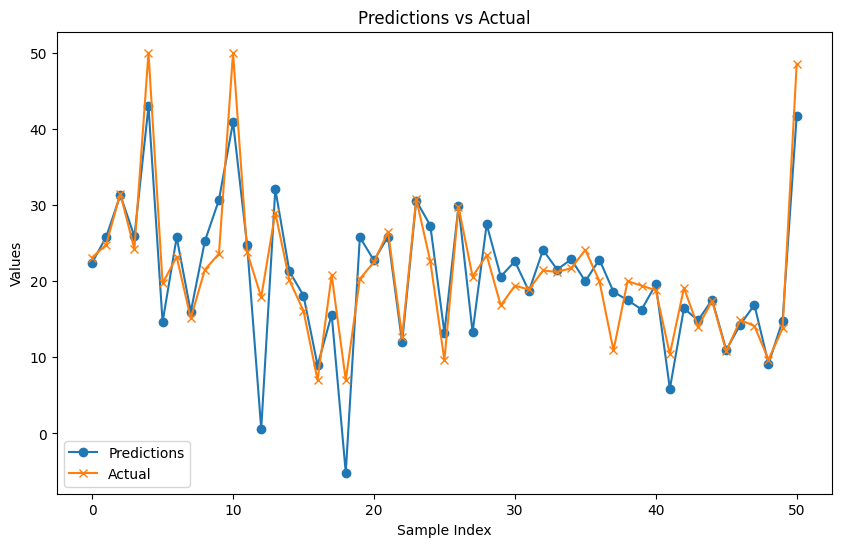

In [32]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = LinearRegressor()
model.fit(X_train, y_train)

# Make predictions and compute confidence metric
predictions_val = model.predict(X_test,y_test)
confidence_metric = model.compute_confidence_metric(X_val, y_val)
mse_lr = mean_squared_error(y_pred=predictions_val,y_true=y_test)

print("Predictions on validation data:", predictions_val)
print("Confidence Metric:", confidence_metric)

model.plot_predictions_vs_actual(predictions_val,y_test)




## MLP Classification (Wine Quality Dataset)

In [81]:
# loading the dataset
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()
print('number of classes : ',num_classes)

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

learning_rate = 0.001
epoches = 100
f=0.64

y = df.iloc[:, -1].values
y = y - 3

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# parameters for the model
# the 1st and last element of layer_sizes correspond to number of features and number of outputs
layer_sizes = [11,5,5,6]
batch_size = 100
num_epoches = 100
learning_rate = 0.02
activation_function = 'ReLU'
optimization = 'mini-batch'

# creating the model object
mlp_c = MLP_Classifier(layer_sizes=layer_sizes,
          batch_size=batch_size,
          num_epoches=num_epoches,
          learning_rate=learning_rate,
          activation_function=activation_function,
          optimization=optimization
         )

mlp_c.loadData(df)
mlp_c.fit(X_train,y_train,X_val,y_val)
y_pred, y_hat ,cr = mlp_c.predict(X_test,y_test,X_val,y_val)

# print('y_pred = ',y_pred)
# print('y_hat = ',y_hat)
print(cr)
acc_mlpc = accuracy_score(y_pred=y_pred,y_true=y_test)



number of classes :  6
              precision    recall  f1-score   support

           0       0.00      0.00      1.00         2
           1       0.00      1.00      0.00         0
           2       0.79      0.55      0.65       243
           3       0.37      0.46      0.41       134
           4       0.20      0.45      0.28        22
           5       0.00      1.00      0.00         0

    accuracy                           0.51       401
   macro avg       0.23      0.58      0.39       401
weighted avg       0.61      0.51      0.55       401



## MLP Regression (Boston Housing Dataset)

number of samples  :  506
number of features :  13
predictions :  [[20.71250355 25.91204853 30.28311579 26.37817263 38.72291818 15.83846601
  21.68365793 17.79331188 20.99676119 29.15616891 37.55614586 22.37196058
   2.64169236 30.67008852 21.89112757 19.85708621 17.59338623 23.61187137
   0.         31.28854666 25.0776955  23.18737087 10.8248523  28.07079369
  24.63025158 16.84797968 27.35927375 18.27123655 29.85725697 15.75350604
  19.48830139 16.08582678 22.32995827 15.85247656 21.72625201 17.9040782
  21.37394404 11.96174674 17.60045146 11.99330922 20.30846199  2.98471221
  13.50544093 18.32319222 22.23302382  8.79741199 17.38582222 14.78647913
  10.97890118 13.49619368 38.13020845]]
confidence Metric :  0.03356548052160379


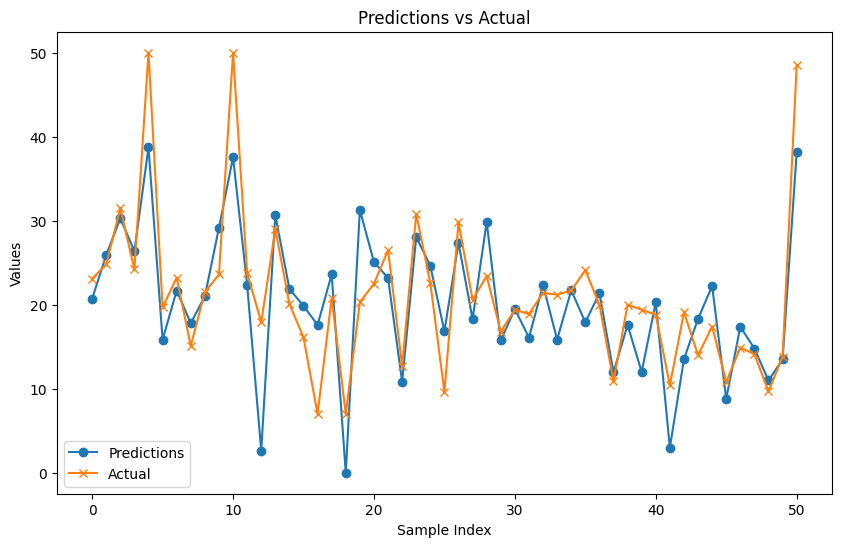

In [33]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# parameters for the model
# the 1st and last element of layer_sizes correspond to number of features and number of outputs
layer_sizes = [13,5,5,1]
batch_size = 10
num_epoches = 500
learning_rate = 0.0001
activation_function = 'ReLU'
optimization = 'mini-batch'

# creating the model object
mlp = MLP_Regressor(layer_sizes=layer_sizes,
          batch_size=batch_size,
          num_epoches=num_epoches,
          learning_rate=learning_rate,
          activation_function=activation_function,
          optimization=optimization,
         )

mlp.loadData(df)
# mlp.printParameters()

mlp.fit(X_train,y_train,X_val,y_val)

predictions_val = mlp.predict(X_test,y_test)
confidence_metric = mlp.compute_confidence_metric(X_val,y_val)

print('predictions : ',predictions_val.reshape(1,-1))
print('confidence Metric : ',confidence_metric)
mse_mlpr = mean_squared_error(y_pred=predictions_val,y_true=y_test)


model.plot_predictions_vs_actual(predictions_val,y_test)


## DecisionTreeClassifier (Wine Quality Dataset)

In [79]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()


X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

learning_rate = 0.001
epoches = 100
f=0.64
f1=0.2/(1-f)

y = df.iloc[:, -1].values
y = y - 3
# first splitting the train data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = MyDecisionTreeClassifier()
model.fit(X_train, y_train)

# Make predictions with details
predictions, soft_assignments, report = model.predict(X_test,y_test, X_val, y_val)

# Print the outputs
print("Predicted Labels:", predictions)
print('Actual Labels : ',y_test)
print("\nClassification Report:")
print(report)

acc_dtc = accuracy_score(y_pred=predictions,y_true=y_test)


Predicted Labels: [2 2 2 4 3 3 2 3 2 2 4 2 3 3 2 4 2 2 3 2 3 3 3 2 3 2 3 3 4 2 3 3 2 4 2 2 2
 2 3 2 2 2 4 3 2 2 3 2 4 2 2 3 2 3 2 3 4 3 2 3 3 2 3 4 3 2 3 2 3 4 4 4 3 4
 3 4 4 3 2 4 2 3 2 3 2 3 2 3 3 3 2 1 2 4 4 2 3 4 2 2 4 3 2 2 2 2 3 3 2 3 4
 3 2 3 3 4 4 4 2 2 2 2 4 3 2 2 2 3 3 3 4 2 2 2 3 3 2 3 2 1 2 2 2 3 2 3 4 2
 2 3 3 3 2 3 2 3 2 3 3 3 3 2 3 2 2 3 2 3 5 3 3 2 2 4 3 2 2 4 2 3 1 3 3 3 2
 4 4 2 2 3 2 3 3 3 2 4 4 2 2 2 2 2 3 3 2 4 2 2 2 2 3 2 2 3 2 2 3 3 4 4 2 2
 2 2 2 3 2 2 3 3 4 2 3 3 2 3 3 2 4 3 3 3 2 4 3 2 2 2 5 3 2 2 2 4 2 2 2 4 2
 3 3 4 2 2 4 2 2 3 2 2 4 2 2 2 2 4 3 2 3 4 2 2 3 3 2 2 3 2 3 3 2 3 3 2 2 3
 2 3 2 3 3 3 2 2 3 4 2 3 2 4 3 4 3 2 2 2 3 4 3 4 5 4 2 3 2 3 3 4 3 2 2 4 3
 3 2 3 4 2 4 2 3 3 2 3 3 4 2 2 3 3 3 3 4 2 3 2 3 3 2 2 3 2 3 4 2 2 3 2 0 2
 3 2 3 2 4 2 4 4 3 3 3 2 2 2 3 1 3 3 4 2 3 3 3 1 2 3 2 1 3 2 2 4 2 3 2 2 2
 2 4 4 4 2 3 2 2 1 3 3 3 3 2 1 3 2 4 3 3 3 2]
Actual Labels :  [3 2 2 3 2 2 3 2 2 3 2 2 3 3 2 4 2 4 4 2 2 2 3 3 2 3 2 3 3 2 4 3 3 4 2 2 4
 3 3 3 2 2 2 3 2 3 

## DecisionTreeRegressor (Boston Housing Dataset)

number of samples  :  506
number of features :  13
Predictions on validation data: [20.3 23.2 29.1 24.8 42.3 17.5 22.6 17.8 20.3 24.6 42.3 23.1 13.4 28.4
 22.6 16.7 12.7 12.3 10.5 21.7 19.3 29.9 15.6 26.6 22.  14.1 25.  11.9
 24.8 20.3 26.4 15.  28.1 22.6 18.8 27.9 20.1 13.3 19.5 15.4 21.4  8.5
 15.4 17.4 19.3  8.3 14.1 14.6  8.3 12.6 50. ]
Confidence Metric: 0.025812982411742375


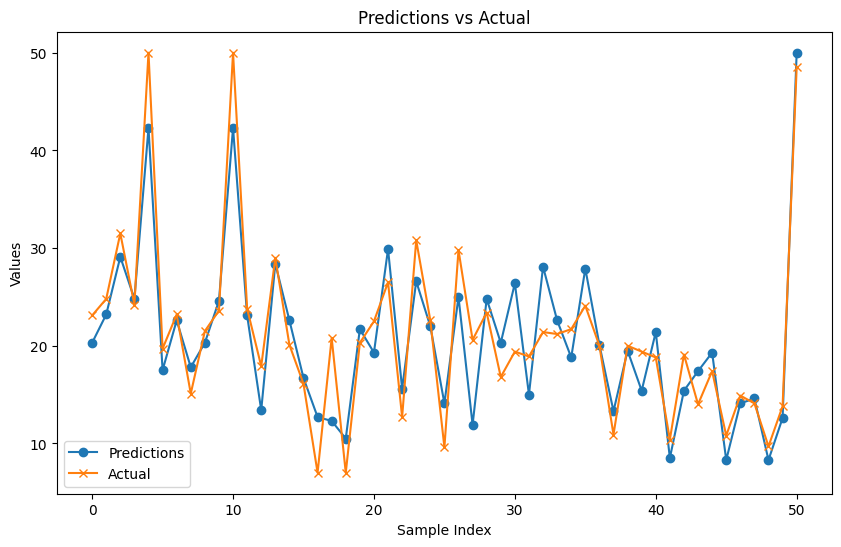

In [34]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = MyDecisionTreeRegressor()
model.fit(X_train, y_train,X_val,y_val)

# Make predictions and compute confidence metric
predictions_val = model.predict(X_test,y_test)
confidence_metric = model.compute_confidence_metric(X_val, y_val)

print("Predictions on validation data:", predictions_val)
print("Confidence Metric:", confidence_metric)
mse_dtr = mean_squared_error(y_pred=predictions_val,y_true=y_test)


model.plot_predictions_vs_actual(predictions_val,y_test)




## Bagging Class

In [18]:
class Bagging_Classifier:
    
    def __init__(self,base_estimator, num_estimators, train_fraction, bootstrap, voting, num_classes=None):
        self.base_estimator = base_estimator
        self.num_estimators = num_estimators
        self.train_fraction = train_fraction
        self.bootstrap = bootstrap
        self.voting_mech = voting
        self.models = []
        self.bsX_train = []
        self.bsy_train = []
        self.bsX_val = []
        self.bsy_val = []
        self.num_classes = num_classes
        self.prediction_task = False
        
        
    def load_dataset(self,X,Y):
        self.X = X
        self.Y = Y
        
        self.num_samples = X.shape[0]
        self.num_features = X.shape[1]

        
    def _bootstrap(self):
        rows = int(self.train_fraction*self.num_samples)
        
        # creating train and validation bootstraps
        for i in range(self.num_estimators):
            if self.bootstrap:
                ind = np.random.choice(range(self.num_samples),size=rows,replace=True)
            else:
                ind = np.random.choice(self.num_samples, size=rows, replace=False)
            x = self.X[ind]
            y = self.Y[ind]
            X_train,X_val,y_train,y_val = train_test_split(x,y,test_size=0.1,random_state=42)
            self.bsX_train.append(X_train)
            self.bsy_train.append(y_train)
            self.bsX_val.append(X_val)
            self.bsy_val.append(y_val)

    
    def fit(self,X_Train,y_train,X_val,y_val):
        print("Fitting models ...")
        for i in range(self.num_estimators):
            if self.base_estimator=='MultinomialLogRegression':
                learning_rate = 0.001
                epoches = 700
                model = MultinomialLogRegression(learning_rate,epoches,6,self.num_features)
                # model.learning_rate = model.learning_rate + 0.1
                model.fit(self.bsX_train[i],self.bsy_train[i],self.bsX_val[i],self.bsy_val[i])
                self.prediction_task = True
                
                
            elif self.base_estimator=='LinearRegressor':
                model = LinearRegressor()
                model.fit(X_train, y_train)
                self.prediction_task=False

                
            elif self.base_estimator=='MLP_Classifier':
                layer_sizes = [11,5,5,6]
                batch_size = 100
                num_epoches = 100
                learning_rate = 0.02
                activation_function = 'ReLU'
                optimization = 'mini-batch'
                # creating the model object
                model = MLP_Classifier(layer_sizes=layer_sizes,
                        batch_size=batch_size,
                        num_epoches=num_epoches,
                        learning_rate=learning_rate,
                        activation_function=activation_function,
                        optimization=optimization
                        )
                model.loadData(df)
                model.fit(X_train,y_train,X_val,y_val)
                self.prediction_task = True


            elif self.base_estimator=='MLP_Regressor':
                layer_sizes = [13,5,5,1]
                batch_size = 10
                num_epoches = 500
                learning_rate = 0.0001
                activation_function = 'ReLU'
                optimization = 'mini-batch'

                # creating the model object
                model = MLP_Regressor(layer_sizes=layer_sizes,
                        batch_size=batch_size,
                        num_epoches=num_epoches,
                        learning_rate=learning_rate,
                        activation_function=activation_function,
                        optimization=optimization,
                        )
                model.loadData(df)
                # mlp.printParameters()
                model.fit(X_train,y_train,X_val,y_val)
                self.prediction_task=False

                
            elif self.base_estimator=='DecisionTreeClassifier':
                model = MyDecisionTreeClassifier()
                model.fit(X_train, y_train)
                self.prediction_task = True

                
            elif self.base_estimator=='DecisionTreeRegressor':
                model = MyDecisionTreeRegressor()
                model.fit(X_train, y_train,X_val,y_val)
                self.prediction_task=False

                
            print('model ',i,' fitted')
            self.models.append(model)



    # for classification tasks
    def predict(self,X_test,y_test,X_val,y_val):
        self.accuracies = []
        
        if self.prediction_task==True:
            if self.voting_mech=='soft':
                return self.soft_predict(X_test,y_test,X_val,y_val)
            else:
                return self.hard_predict(X_test,y_test,X_val,y_val)
        else:
            if self.voting_mech=='soft':
                return self.soft_regress(X_test,y_test,X_val,y_val)
            else:
                return self.hard_regress(X_test,y_test)


    def soft_regress(self,X_test,y_test,X_val,y_val):
        regressions = np.zeros(X_test.shape[0])
        sum = 0
        
        for i in range(self.num_estimators):
            predictions = self.models[i].predict(X_test,y_test)
            predictions = predictions.reshape(-1,1)
            confidence_metric = self.models[i].compute_confidence_metric(X_val,y_val)
            # regressions = np.sum([regressions,(confidence_metric*predictions)],axis=0)
            regressions = regressions.flatten()
            predictions = predictions.flatten()
            # print('regress : ',regressions)
            # print('add : ',predictions)
            regressions = regressions + (confidence_metric*predictions)
            sum = sum + confidence_metric
        
        regressions = regressions / sum
        return regressions
            
        
    def hard_regress(self,X_test,y_test):
        regressions = np.zeros(X_test.shape[0])
        sum = 0
        
        for i in range(self.num_estimators):
            predictions = self.models[i].predict(X_test,y_test)
            confidence_metric = 1
            regressions = regressions.flatten()
            predictions = predictions.flatten()

            regressions = regressions + confidence_metric*predictions
            sum = sum + confidence_metric
        
        regressions = regressions / sum
        return regressions

    # soft prediction for classification
    def soft_predict(self,X_test,y_test,X_val,y_val):
        predictions = np.empty((0,X_test.shape[0],self.num_classes))
        
        for i in range(self.num_estimators):
            y_pred, y_hat, _ =self.models[i].predict(X_test,y_test,X_val,y_val)
            predictions = np.append(predictions,[y_hat],axis=0)
            correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
            total_predictions = len(y_test)
            accuracy = (correct_predictions / total_predictions) * 100
            # print(f'Accuracy: {accuracy:.2f}%')
            self.accuracies.append(accuracy)

        pred = np.sum(predictions,axis=0)
        output_labels = np.argmax(pred, axis=1)        
        return output_labels
    
    
    
    # hard prediction for classification
    def hard_predict(self,X_test,y_test,X_val,y_val):
        predictions = []
        for i in range(self.num_estimators):
            y_pred,y_hat,_ = self.models[i].predict(X_test,y_test,X_val,y_val)
            predictions.append(y_pred)
            correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
            total_predictions = len(y_test)
            accuracy = (correct_predictions / total_predictions) * 100
            # print(f'Accuracy: {accuracy:.2f}%')
            self.accuracies.append(accuracy)

        stacked_predictions = np.vstack(predictions)
        # Find the most frequently occurring value in each column
        most_frequent_values, _ = mode(stacked_predictions, axis=0)
        # Convert the result to a numpy array
        result_array = most_frequent_values.squeeze()
        return result_array
    
    
        

## Classification using Bagging

In [24]:

# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

learning_rate = 0.001
epoches = 100
f=0.5

y = df.iloc[:, -1].values
y = y - 3


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
 
# mlr = MultinomialLogRegression(learning_rate,epoches,num_classes,num_features)


In [35]:
MLR = 'MultinomialLogRegression'
LR = 'LinearRegressor'
MLPC = 'MLP_Classifier'
MLPR = 'MLP_Regressor'
DTC = 'DecisionTreeClassifier'
DTR = 'DecisionTreeRegressor'


bc = Bagging_Classifier(MLR,5,0.15,False,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)
print('predicted labels : ',result)
print('Actual labels : ',y_test)


y_pred = result
correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
total_predictions = len(y_test)
accuracy = (correct_predictions / total_predictions) * 100
print(f'Accuracy: {accuracy:.2f}%')

print('Base Learners accuracies : ',bc.accuracies)

Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
predicted labels :  [2 4 2 3 2 3 4 3 2 4 4 3 2 3 2 3 4 2 3 2 3 2 2 3 2 4 4 2 2 5 2 2 4 2 3 4 4
 4 2 2 2 2 4 3 3 4 3 3 3 4 2 3 3 2 2 2 4 4 4 3 2 2 2 3 2 2 3 2 4 2 2 4 3 2
 2 2 2 2 2 2 2 2 3 3 4 3 2 2 4 3 2 3 4 4 4 3 2 4 4 2 3 4 3 3 2 2 2 4 3 4 2
 2 2 3 2 3 4 4 2 2 3 2 4 4 4 2 4 4 3 3 2 4 4 3 2 2 3 4 2 4 2 2 2 2 3 2 3 3
 3 1 2 3 2 3 2 2 3 3 2 2 2 3 2 2 3 3 2 3 3 4 2 3 2 2 4 2 2 4 2 2 4 2 3 2 3
 3 2 3 3 2 4 2 2 2 2 4 4 3 3 2 2 2 2 3 3 3 4 3 2 3 3 2 2 2 2 3 3 2 2 2 2 3
 3 2 2 3 2 3 2 4 4 4 3 3 2 3 3 2 3 2 2 0 4 3 3 2 4 4 3 2 3 4 3 3 2 2 2 2 2
 4 2 3 4 3 4 4 3 4 1 3 2 2 2 3 3 2 3 3 4 3 2 4 2 3 3 2]
Actual labels :  [2 3 2 2 2 3 3 3 3 3 4 3 3 3 2 3 3 2 3 1 3 2 2 3 2 2 2 2 2 3 3 2 3 2 3 4 4
 4 2 2 2 2 3 3 2 4 2 3 1 3 2 3 3 2 2 3 4 2 2 3 3 2 3 2 2 2 3 2 3 3 2 3 1 3
 3 2 2 2 2 3 4 2 3 2 3 3 2 2 4 3 3 3 3 3 2 4 2 4 3 2 2 4 2 2 3 3 3 4 1 3 2
 3 2 3 2 3 3 4 2 3 3 3 2 4 3 2 5 4 2 2 2 3 3 4 2 2 3 

## Regression using Bagging

In [88]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



number of samples  :  506
number of features :  13


In [89]:
MLR = 'MultinomialLogRegression'
LR = 'LinearRegressor'
MLPC = 'MLP_Classifier'
MLPR = 'MLP_Regressor'
DTC = 'DecisionTreeClassifier'
DTR = 'DecisionTreeRegressor'


bc = Bagging_Classifier(DTR,7,0.75,False,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)


print('predicted values : ',np.round(result,2))
print('origial values : ',y_test.reshape(1,-1))

mse = mean_squared_error(y_pred=result,y_true=y_test)
print('mean squared error : ',mse)
# correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
# total_predictions = len(y_test)
# accuracy = (correct_predictions / total_predictions) * 100
# print(f'Accuracy: {accuracy:.2f}%')

# print(bc.accuracies)

Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
predicted values :  [21.08 23.18 29.58 24.62 42.31 18.48 22.83 17.14 21.08 24.32 42.83 23.1
 14.28 30.05 22.7  16.7  12.51 12.48  9.85 21.83 19.18 29.67 15.15 27.53
 22.   14.37 24.21 11.9  24.42 20.97 26.4  15.54 26.9  22.51 18.91 27.47
 21.04 13.24 19.31 15.74 20.62  8.47 16.1  17.5  19.3   8.3  14.38 15.25
  8.3  12.82 50.  ]
origial values :  [[23.1 24.8 31.5 24.2 50.  19.7 23.2 15.1 21.5 23.6 50.  23.8 17.9 29.
  20.1 16.1  7.  20.8  7.  20.3 22.5 26.5 12.7 30.8 22.6  9.6 29.8 20.6
  23.4 16.8 19.4 18.9 21.4 21.2 21.7 24.1 20.  10.9 20.  19.4 18.8 10.4
  19.1 14.  17.4 10.8 14.9 14.1  9.7 13.8 48.5]]
mean squared error :  12.202708408023378


## Hyperparameter Tuning (Classification)

In [212]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

learning_rate = 0.001
epoches = 100
f=0.5

y = df.iloc[:, -1].values
y = y - 3


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
 
# mlr = MultinomialLogRegression(learning_rate,epoches,num_classes,num_features)


In [213]:

fraction_vals = [0.15, 0.25, 0.75, 1]
bootstrap_vals = [True, False]
voting_vals = ['soft','hard']
base_est_vals = [MLR, MLPC, DTC]
num_est_vals = 3

a = 1
b = 8

i = 0
for f_val in fraction_vals:
    for b_val in bootstrap_vals:
        for v_val in voting_vals:
            for be_val in base_est_vals:
                for i in range(num_est_vals):
                    random_integer = np.random.randint(a, b + 1)
                    i = i +1
                    wandb.init(
                        # set the wandb project where this run will be logged
                        project="Bagging Classifier",

                        # track hyperparameters and run metadata
                        config={
                        'base_estimator' : be_val,
                        'num_estimators' : random_integer,
                        'fraction' : f_val,
                        'Bootstrap' : b_val,
                        'Voting Mech' : v_val
                        }
                    )                    
                    bc = Bagging_Classifier(be_val,random_integer,f_val,b_val,v_val,num_classes=6)
                    bc.load_dataset(X,y)
                    bc._bootstrap()
                    bc.fit(X_train,y_train,X_val,y_val)
                    result = bc.predict(X_test,y_test,X_val,y_val)
                    # print('predicted labels : ',result)
                    y_pred = result
                    correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
                    total_predictions = len(y_test)
                    accuracy = (correct_predictions / total_predictions) * 100
                    # print(f'Accuracy: {accuracy:.2f}%')
                    wandb.log({"accuracy": accuracy})
                    # print(bc.accuracies)
                    print(i,' runs done!!!')



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: tejas591995. Use `wandb login --relogin` to force relogin


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.4965


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.24476


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.29371


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.29371


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.4965


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.0979


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,49.65035


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,58.04196


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,45.45455


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.14685


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,49.65035


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.94406


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,50.0


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,50.6993


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.0979


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.24476


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.29371


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.74825


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.74825


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.24476


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,50.34965


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.99301


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.29371


Fitting models ...
model  0  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.74825


Fitting models ...
model  0  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.0979


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,57.34266


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,50.0


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.24476


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.24476


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,49.65035


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.74825


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.99301


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,57.34266


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.14685


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.0979


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.74825


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.4965


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.59441


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.99301


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.74825


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,57.34266


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.29371


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.84615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,56.29371


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.0979


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.74825


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.14685


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.0979


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.4965


Fitting models ...
model  0  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.14685


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.04895


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.8951


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.4965


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.7972


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,52.44755


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.1958


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,49.3007


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.24476


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,51.3986


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,55.94406


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,54.54545


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
accuracy,53.14685


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


### Following are the hyper-parameters of the best performing model (classification)
- bootstrap : false
- voting mechanism : soft
- base estimator : Multinomial Logistic Regressor
- fraction : 0.15
- number of estimators : 5
- Accuracy : 0.5804

---
## Hyperparameter Tuning (Regression)

In [28]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



number of samples  :  506
number of features :  13


In [23]:

fraction_vals = [0.15, 0.25, 0.75, 1]
bootstrap_vals = [True, False]
voting_vals = ['soft','hard']
base_est_vals = [LR, MLPR, DTR]
num_est_vals = 3

a = 1
b = 8

i = 0
for f_val in fraction_vals:
    for b_val in bootstrap_vals:
        for v_val in voting_vals:
            for be_val in base_est_vals:
                for i in range(num_est_vals):
                    random_integer = np.random.randint(a, b + 1)
                    i = i +1
                    wandb.init(
                        # set the wandb project where this run will be logged
                        project="Bagging Regressor",

                        # track hyperparameters and run metadata
                        config={
                        'base_estimator' : be_val,
                        'num_estimators' : random_integer,
                        'fraction' : f_val,
                        'Bootstrap' : b_val,
                        'Voting Mech' : v_val
                        }
                    )                    
                    bc = Bagging_Classifier(be_val,random_integer,f_val,b_val,v_val,num_classes=6)
                    bc.load_dataset(X,y)
                    bc._bootstrap()
                    bc.fit(X_train,y_train,X_val,y_val)
                    result = bc.predict(X_test,y_test,X_val,y_val)
                    
                    mse = mean_squared_error(y_pred=result,y_true=y_test)
                    rmse = np.sqrt(mse)
                    r_squared = r2_score(y_pred=result,y_true=y_test)
                    wandb.log({"MSE": mse, "RMSE":rmse, "R-squared":r_squared})
                    
                    print(i,' runs done!!!')



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: tejas591995. Use `wandb login --relogin` to force relogin


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.809
R-squared,0.7612
RMSE,4.45073


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.8899
R-squared,0.79639
RMSE,4.10973


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.52241
R-squared,0.78877
RMSE,4.18598


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.50989
R-squared,0.84919
RMSE,3.53693


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.58806
R-squared,0.87236
RMSE,3.25393


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.94825
R-squared,0.85597
RMSE,3.45662


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.49945
R-squared,0.77699
RMSE,4.3011


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,33.89366
R-squared,0.59142
RMSE,5.82183


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,25.06349
R-squared,0.69786
RMSE,5.00635


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.21089
R-squared,0.8528
RMSE,3.49441


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.07298
R-squared,0.85446
RMSE,3.47462


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.81028
R-squared,0.85763
RMSE,3.43661


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,25.5354
R-squared,0.69217
RMSE,5.05326


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.13736
R-squared,0.80547
RMSE,4.01713


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.29312
R-squared,0.79153
RMSE,4.1585


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.66078
R-squared,0.84738
RMSE,3.5582


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.31651
R-squared,0.85153
RMSE,3.50949


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.71655
R-squared,0.85876
RMSE,3.42295


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.28151
R-squared,0.71934
RMSE,4.82509


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.17456
R-squared,0.76885
RMSE,4.37888


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.44945
R-squared,0.74143
RMSE,4.63136


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.06627
R-squared,0.85454
RMSE,3.47365


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.61421
R-squared,0.85999
RMSE,3.40796


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.8944
R-squared,0.84456
RMSE,3.59088


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,38.25022
R-squared,0.5389
RMSE,6.18468


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,26.15207
R-squared,0.68474
RMSE,5.11391


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.43738
R-squared,0.77774
RMSE,4.29388


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.6742
R-squared,0.84721
RMSE,3.56008


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.56165
R-squared,0.86063
RMSE,3.40024


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.9125
R-squared,0.8564
RMSE,3.45145


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.8274
R-squared,0.83331
RMSE,3.71852


Fitting models ...
model  0  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,29.18478
R-squared,0.64818
RMSE,5.40229


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,34.94306
R-squared,0.57876
RMSE,5.91127


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.40176
R-squared,0.86255
RMSE,3.37665


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.43121
R-squared,0.85014
RMSE,3.52579


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.65
R-squared,0.85956
RMSE,3.41321


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,27.34797
R-squared,0.67032
RMSE,5.22953


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.62929
R-squared,0.78748
RMSE,4.19873


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.60574
R-squared,0.77571
RMSE,4.31344


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.54947
R-squared,0.84872
RMSE,3.54252


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.26065
R-squared,0.8522
RMSE,3.50152


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.39117
R-squared,0.83857
RMSE,3.6594


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,44.17135
R-squared,0.46752
RMSE,6.64615


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.95277
R-squared,0.80769
RMSE,3.99409


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.37699
R-squared,0.73025
RMSE,4.73043


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.52882
R-squared,0.83691
RMSE,3.67815


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.87895
R-squared,0.8568
RMSE,3.44658


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.96804
R-squared,0.86778
RMSE,3.3118


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.33654
R-squared,0.74279
RMSE,4.61915


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.28403
R-squared,0.77959
RMSE,4.27598


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.63677
R-squared,0.72712
RMSE,4.75781


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.88846
R-squared,0.85669
RMSE,3.44796


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.03697
R-squared,0.8549
RMSE,3.46943


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.58622
R-squared,0.86033
RMSE,3.40385


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.81036
R-squared,0.7853
RMSE,4.22023


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,38.76146
R-squared,0.53273
RMSE,6.22587


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,34.91388
R-squared,0.57912
RMSE,5.9088


Fitting models ...
model  0  fitted
model  1  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.94882
R-squared,0.85596
RMSE,3.45671


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.00046
R-squared,0.85534
RMSE,3.46417


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.75371
R-squared,0.84626
RMSE,3.57123


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.87195
R-squared,0.7725
RMSE,4.34419


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.94693
R-squared,0.71132
RMSE,4.89356


Fitting models ...
model  0  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,40.10837
R-squared,0.5165
RMSE,6.33312


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.9051
R-squared,0.8806
RMSE,3.14724


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.41568
R-squared,0.86239
RMSE,3.37871


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.07673
R-squared,0.86647
RMSE,3.32817


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.24123
R-squared,0.7801
RMSE,4.27098


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,25.44281
R-squared,0.69329
RMSE,5.04409


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.65031
R-squared,0.79928
RMSE,4.08048


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.82588
R-squared,0.8695
RMSE,3.29027


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.83306
R-squared,0.85735
RMSE,3.43992


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.77833
R-squared,0.8339
RMSE,3.71192


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.66487
R-squared,0.81116
RMSE,3.95789


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,33.32386
R-squared,0.59828
RMSE,5.77268


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,44.40478
R-squared,0.4647
RMSE,6.66369


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.32349
R-squared,0.85144
RMSE,3.51048


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.44698
R-squared,0.86201
RMSE,3.38334


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.77534
R-squared,0.84599
RMSE,3.57426


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.29038
R-squared,0.80362
RMSE,4.03613


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,25.88512
R-squared,0.68796
RMSE,5.08774


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,24.21413
R-squared,0.7081
RMSE,4.92079


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.13823
R-squared,0.86573
RMSE,3.3374


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.68347
R-squared,0.85916
RMSE,3.41811


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.5099
R-squared,0.86125
RMSE,3.39262


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.75356
R-squared,0.81009
RMSE,3.96907


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.35811
R-squared,0.76664
RMSE,4.39979


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.57952
R-squared,0.80014
RMSE,4.0718


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.62514
R-squared,0.84781
RMSE,3.55319


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.857
R-squared,0.85707
RMSE,3.4434


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.60491
R-squared,0.8601
RMSE,3.4066


Fitting models ...
model  0  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.23246
R-squared,0.74404
RMSE,4.60787


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.87965
R-squared,0.71213
RMSE,4.88668


Fitting models ...
model  0  fitted
model  1  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,24.7259
R-squared,0.70193
RMSE,4.97251


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
3  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.90801
R-squared,0.72385
RMSE,4.78623


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
1  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.17142
R-squared,0.84122
RMSE,3.62924


Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
2  runs done!!!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.42676
R-squared,0.8502
RMSE,3.52516


Fitting models ...
model  0  fitted
model  1  fitted
3  runs done!!!


### Following are the hyper-parameters of the best performing model (regression)
- bootstrap : true
- voting mechanism : soft
- base estimator : Decision Tree Regressor
- fraction : 0.75
- number of estimators : 7
- RMSE : 3.404
- Run name : ethereal-field

---
### Heatmap for Regression

In [29]:
n_vals = [3,5,9,11,15]
f_vals = [0.15,0.25,0.5,0.75,1]

hm_dt = np.zeros((5,5))
hm_lr = np.zeros((5,5))
hm_mlp = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        n = n_vals[i]
        f = f_vals[j]
        
        bc = Bagging_Classifier(DTR,n,f,True,'soft',num_classes=6)
        bc.load_dataset(X,y)
        bc._bootstrap()
        bc.fit(X_train,y_train,X_val,y_val)
        result = bc.predict(X_test,y_test,X_val,y_val)
        mse = mean_squared_error(y_pred=result,y_true=y_test)
        hm_dt[i,j] = mse
        print('DTR done!')
        
        bc = Bagging_Classifier(LR,n,f,True,'soft',num_classes=6)
        bc.load_dataset(X,y)
        bc._bootstrap()
        bc.fit(X_train,y_train,X_val,y_val)
        result = bc.predict(X_test,y_test,X_val,y_val)
        mse = mean_squared_error(y_pred=result,y_true=y_test)
        hm_lr[i,j] = mse
        print('LR done!')
        
        bc = Bagging_Classifier(MLPR,n,f,True,'soft',num_classes=6)
        bc.load_dataset(X,y)
        bc._bootstrap()
        bc.fit(X_train,y_train,X_val,y_val)
        result = bc.predict(X_test,y_test,X_val,y_val)
        mse = mean_squared_error(y_pred=result,y_true=y_test)
        hm_mlp[i,j] = mse
        print('MLPR done!')




Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
DTR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
LR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
MLPR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
DTR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
LR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
MLPR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
DTR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
LR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
MLPR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
DTR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
LR done!
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
MLPR done!
Fitting models ...
model  0  fitted
mode

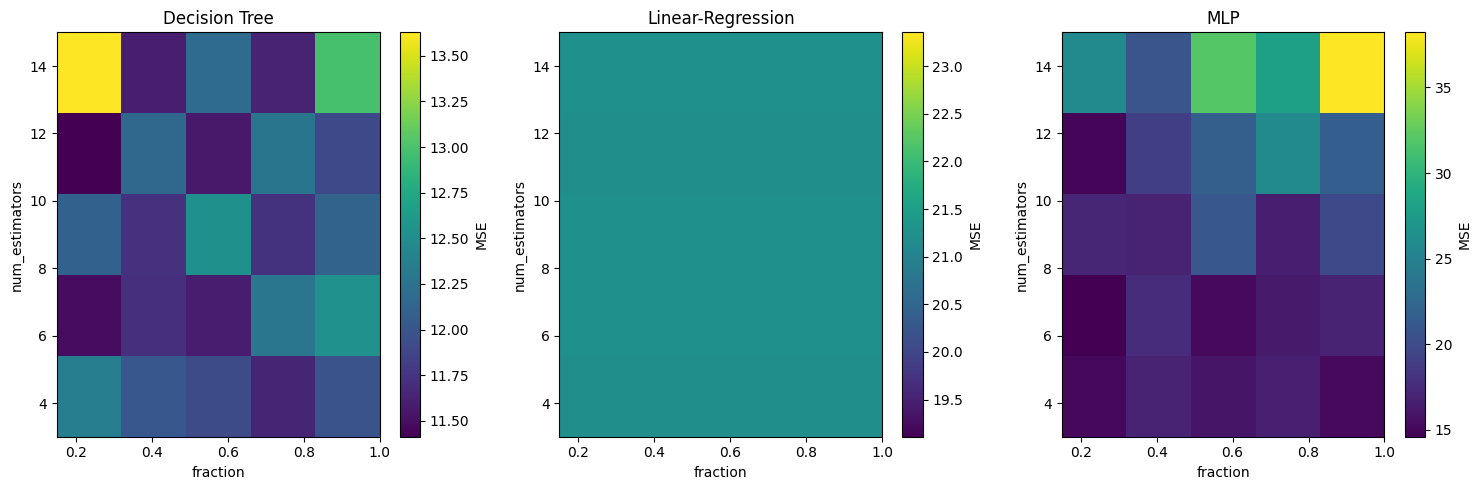

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


im1 = axes[0].imshow(hm_dt, cmap='viridis', extent=[min(f_vals), max(f_vals), min(n_vals), max(n_vals)], aspect='auto')
axes[0].set_title('Decision Tree')
axes[0].set_xlabel('fraction')
axes[0].set_ylabel('num_estimators')
fig.colorbar(im1, ax=axes[0], label='MSE')

im2 = axes[1].imshow(hm_lr, cmap='viridis', extent=[min(f_vals), max(f_vals), min(n_vals), max(n_vals)], aspect='auto')
axes[1].set_title('Linear-Regression')
axes[1].set_xlabel('fraction')
axes[1].set_ylabel('num_estimators')
fig.colorbar(im2, ax=axes[1], label='MSE')

im3 = axes[2].imshow(hm_mlp, cmap='viridis', extent=[min(f_vals), max(f_vals), min(n_vals), max(n_vals)], aspect='auto')
axes[2].set_title('MLP')
axes[2].set_xlabel('fraction')
axes[2].set_ylabel('num_estimators')
fig.colorbar(im3, ax=axes[2], label='MSE')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### heatmap for Classification

In [ ]:
n_vals = [3,5,9,11,15]
f_vals = [0.15,0.25,0.5,0.75,1]

hm_dt = np.zeros((5,5))
hm_mlr = np.zeros((5,5))
hm_mlp = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        n = n_vals[i]
        f = f_vals[j]
        
        bc = Bagging_Classifier(DTC,n,f,False,'soft',num_classes=6)
        bc.load_dataset(X,y)
        bc._bootstrap()
        bc.fit(X_train,y_train,X_val,y_val)
        result = bc.predict(X_test,y_test,X_val,y_val)
        y_pred = result
        correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
        total_predictions = len(y_test)
        accuracy = (correct_predictions / total_predictions) * 100
        hm_dt[i,j] = accuracy
        
        bc = Bagging_Classifier(MLR,n,f,False,'soft',num_classes=6)
        bc.load_dataset(X,y)
        bc._bootstrap()
        bc.fit(X_train,y_train,X_val,y_val)
        result = bc.predict(X_test,y_test,X_val,y_val)
        y_pred = result
        correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
        total_predictions = len(y_test)
        accuracy = (correct_predictions / total_predictions) * 100
        hm_mlr[i,j] = accuracy
        
        bc = Bagging_Classifier(MLPC,n,f,False,'soft',num_classes=6)
        bc.load_dataset(X,y)
        bc._bootstrap()
        bc.fit(X_train,y_train,X_val,y_val)
        result = bc.predict(X_test,y_test,X_val,y_val)
        y_pred = result
        correct_predictions = sum([1 for pred, true in zip(y_pred, y_test) if pred == true])
        total_predictions = len(y_test)
        accuracy = (correct_predictions / total_predictions) * 100
        hm_mlp[i,j] = accuracy




Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
Fitting models ...
m

/tmp/ipykernel_27022/520088668.py:94: RuntimeWarning: invalid value encountered in divide
  return ar/ar.sum(axis=1,keepdims=True)


model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
model  8  fitted
model  9  fitted
model  10  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
model  8  fitted
model  9  fitted
model  10  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
model  8  fitted
model  9  fitted
model  10  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
model  8  fitted
model  9  fitted
model  10  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
model  7  fitted
model  8  fitted
model  9  fitted
model  10  fitted
Fitting models ...

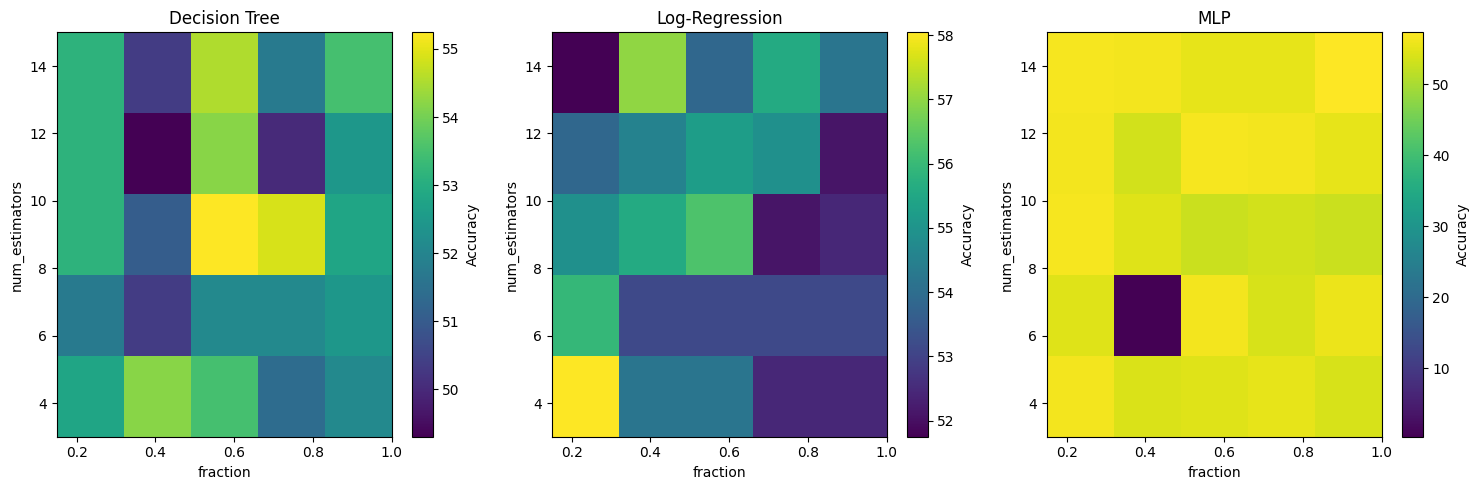

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


im1 = axes[0].imshow(hm_dt, cmap='viridis', extent=[min(f_vals), max(f_vals), min(n_vals), max(n_vals)], aspect='auto')
axes[0].set_title('Decision Tree')
axes[0].set_xlabel('fraction')
axes[0].set_ylabel('num_estimators')
fig.colorbar(im1, ax=axes[0], label='Accuracy')

im2 = axes[1].imshow(hm_mlr, cmap='viridis', extent=[min(f_vals), max(f_vals), min(n_vals), max(n_vals)], aspect='auto')
axes[1].set_title('Log-Regression')
axes[1].set_xlabel('fraction')
axes[1].set_ylabel('num_estimators')
fig.colorbar(im2, ax=axes[1], label='Accuracy')

im3 = axes[2].imshow(hm_mlp, cmap='viridis', extent=[min(f_vals), max(f_vals), min(n_vals), max(n_vals)], aspect='auto')
axes[2].set_title('MLP')
axes[2].set_xlabel('fraction')
axes[2].set_ylabel('num_estimators')
fig.colorbar(im3, ax=axes[2], label='Accuracy')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Comparison of models

### Regression

In [ ]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



number of samples  :  506
number of features :  13


In [42]:
bc = Bagging_Classifier(LR,7,0.75,True,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)
mse_e1 = mean_squared_error(y_pred=result,y_true=y_test)

bc = Bagging_Classifier(MLPR,7,0.75,True,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)
mse_e2 = mean_squared_error(y_pred=result,y_true=y_test)

bc = Bagging_Classifier(DTR,7,0.75,True,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)
mse_e3 = mean_squared_error(y_pred=result,y_true=y_test)





Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
model  5  fitted
model  6  fitted


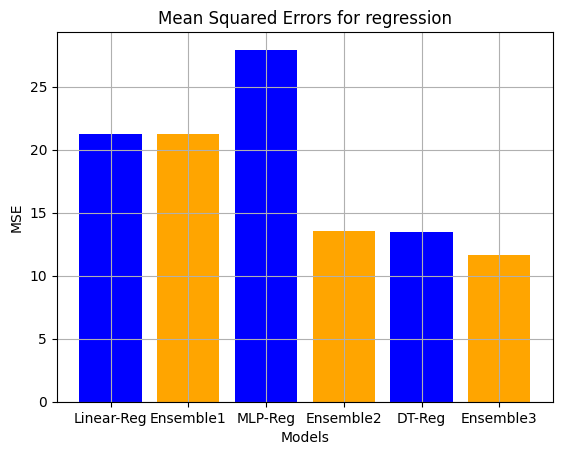

[21.23 21.23 27.94 13.56 13.45 11.68]


In [86]:
values = [mse_lr,mse_e1, mse_mlpr,mse_e2, mse_dtr, mse_e3]
labels = ['Linear-Reg', 'Ensemble1', 'MLP-Reg', 'Ensemble2', 'DT-Reg', 'Ensemble3']

colors = ['blue' if i % 2 == 0 else 'orange' for i in range(6)]
plt.bar(labels, values, color=colors)

plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Mean Squared Errors for regression')
plt.grid()
plt.show()

print(np.round(values,2))


### Classification

In [44]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

learning_rate = 0.001
epoches = 100
f=0.5

y = df.iloc[:, -1].values
y = y - 3


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
 
# mlr = MultinomialLogRegression(learning_rate,epoches,num_classes,num_features)


In [48]:
bc = Bagging_Classifier(MLR,5,0.15,False,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)
acc_e1 = accuracy_score(y_pred=result,y_true=y_test)

bc = Bagging_Classifier(MLPC,5,0.15,False,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)
acc_e2 = accuracy_score(y_pred=result,y_true=y_test)

bc = Bagging_Classifier(DTC,5,0.15,False,'soft',num_classes=6)
bc.load_dataset(X,y)
bc._bootstrap()
bc.fit(X_train,y_train,X_val,y_val)
result = bc.predict(X_test,y_test,X_val,y_val)
acc_e3 = accuracy_score(y_pred=result,y_true=y_test)



Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted
Fitting models ...
model  0  fitted
model  1  fitted
model  2  fitted
model  3  fitted
model  4  fitted


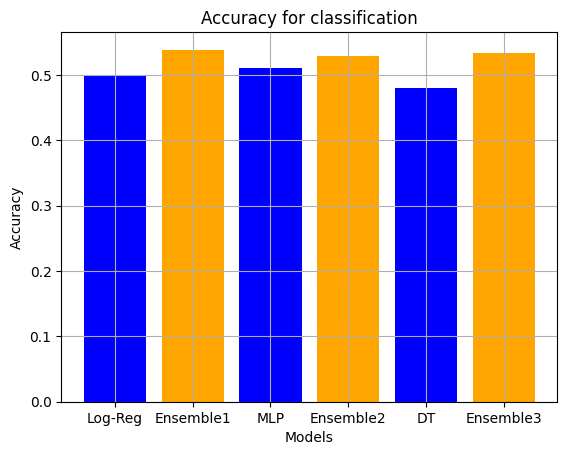

[0.5  0.54 0.51 0.53 0.48 0.53]


In [85]:
values = [acc_mlr,acc_e1, acc_mlpc,acc_e2, acc_dtc, acc_e3]
labels = ['Log-Reg', 'Ensemble1', 'MLP', 'Ensemble2', 'DT', 'Ensemble3']

colors = ['blue' if i % 2 == 0 else 'orange' for i in range(6)]
plt.bar(labels, values, color=colors)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy for classification')
plt.grid()
plt.show()

print(np.round(values,2))